In [16]:
%matplotlib inline

import numpy as np
import os
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from PIL import Image
import math

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [14]:
def images_square_grid(images, mode):

    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

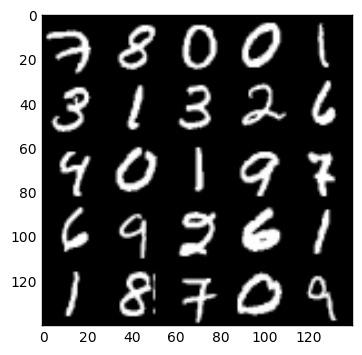

In [23]:
num_img = 25
img = mnist.train.images[:num_img]
img = img.reshape(num_img,28,28,1)

plt.imshow(images_square_grid(img, 'L'), cmap='gray')
#plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [76]:
# Create the model inputs
def model_inputs(image_width, image_height, image_channels, embedded_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    #input real images
    real_input_images = tf.placeholder(tf.float32, \
                                       shape=(None,image_width,\
                                              image_height,\
                                              image_channels))
    
    # target real images for autoencoder
    target_input_images = tf.placeholder(tf.float32, \
                                        shape=(None,image_width,\
                                              image_height,\
                                              image_channels))
    
    # input embedding data for generator
    embedded_data = tf.placeholder(tf.float32, \
                           shape=(None,embedded_dim))
    
    # learning rate
    learning_rate = tf.placeholder(tf.float32, \
                                  shape=None)

    print('inputs, real_input_images: ',real_input_images)
    print('inputs, target_input_images: ',target_input_images)
    return real_input_images, target_input_images, embedded_data, learning_rate

In [77]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
            return tf.maximum(x, alpha * x, name=name)

In [165]:
# encoding network
def encoder(images, embedded_dim, reuse=False):


    with tf.variable_scope('encoder', reuse=reuse):
        
        # Input layer is 28x28x1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = leaky_relu(conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = leaky_relu(bn3)
        #7x7x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        
        # Dropout
        dropout = tf.nn.dropout(flat,0.8)
        
        # Logits
        logits = tf.layers.dense(dropout, embedded_dim,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        
        
    return out, logits

In [181]:
# Generator
def generator(embedding, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(embedding, 7*7*512,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1,0.5)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2,0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3,0.5)
        # 28x28x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.sigmoid(logits)
    
    return out, logits

In [178]:
# Descriminator
def descriminator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1,0.5)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2,0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3,0.5)
        # 28x28x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out

In [130]:
# Classifier
def classifier(embedded_values, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(embedded_values, 7*7*512,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1,0.5)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2,0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3,0.5)
        # 28x28x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out

In [182]:
def model_loss(input_real, out_channel_dim, target_real, embedded_dim): #, input_z
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator for fake images
#     g_logits = generator(input_z, out_channel_dim, is_train=True, reuse=True)
    
    # encoder for real and faked images
    e_model_real, e_logits_real = encoder(input_real, embedded_dim, reuse=False)
#     e_model_fake, e_logits_fake = encoder(g_logits, reuse=True)
    
    # descriminator for real and faked images
#     d_model_real, d_logits_real = discriminator(e_model_encoder_real, reuse=False)
#     d_model_fake, d_logits_fake = discriminator(e_model_encoder_fake, reuse=True)
    
    # classifier
#     c_model_real, c_logits_real = classifier(e_model_encoder_real, reuse=False)
#     c_model_fake, c_logits_fake = classifier(e_model_encoder_fake, reuse=True)
    
    # autoencoder
    a_model_real, a_logits_real = generator(e_logits_real, out_channel_dim, is_train=True)
    
    # descriminator loss
#     d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
#                                                 labels=tf.ones_like(d_model_real) * (1-smooth)))
#     d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
#                                                 labels=tf.zeros_like(d_model_fake)))
#     d_loss = d_loss_real + d_loss_fake
    
    # generator loss
    # fake comparing descriminator with '1'
#     g_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    # real comparing input_real with autoencoder image
    print('target_real: ',target_real)
    print('a_mode_real: ',a_model_real)
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_real, logits=a_model_real))
#     g_cost_real = tf.reduce_mean(g_loss_real)
    
#     g_loss = g_loss_fake + g_loss_real
    
    #TODO Classifier loss
    
    return g_loss_real, a_model_real  #d_loss, g_loss_fake, 

In [183]:
def model_opt(g_auto_loss,learning_rate, beta1): #, g_loss, e_loss, c_loss, 
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
#     d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
#     g_vars = [var for var in t_vars if var.name.startswith('generator')]
#     e_vars = [var for var in t_vars if var.name.startswith('encoder')]
#     c_vars = [var for var in t_vars if var.name.startswith('classifier')]
    
#     print('g_vars: ',g_vars)
#     print('d_vars: ',d_vars)
    auto_enc_vars = [var for var in t_vars if (var.name.startswith('generator') or var.name.startswith('discriminator'))]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_auto_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_auto_loss, var_list=auto_enc_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
#         e_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(e_loss, var_list=d_vars)
#         c_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(c_loss, var_list=g_vars)

    return g_auto_train_opt#, g_train_opt, e_train_opt, c_train_opt

In [208]:
def show_autoencoder_output(sess, n_images, real_input_images, input_images, auto_logits, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    batch_images = mnist.train.next_batch(n_images)
    batch_images = batch_images[0].reshape((-1,data_shape,data_shape,1))
    batch_images = batch_images + 0.3 * np.random.randn(*batch_images.shape)
    clear_output()
    cmap = None if image_mode == 'RGB' else 'gray'
#     z_dim = input_z.get_shape().as_list()[-1]
#     example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
#     example_z = np.random.normal(0.,1.,size=[n_images, z_dim])
    samples = sess.run(
        auto_logits,
        feed_dict={real_input_images: batch_images})

    images_grid = images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

In [216]:
def train(epoch_count, batch_size, embedded_dim, learning_rate, beta1, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 100
    show_every = 1000
    
    samples, losses = [], []
    steps = 0
    
   
    real_input_images, target_images, embed_input, learn_rate = model_inputs(data_shape, data_shape, len(data_image_mode), embedded_dim)
    #d_loss, g_loss = model_loss(real_input_images, z_data, len(data_image_mode))
    print('target_images: ',target_images)
    g_auto_loss, auto_logits =  model_loss(real_input_images, len(data_image_mode), target_images, embedded_dim)
        
    g_auto_opt = model_opt(g_auto_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):

            for ii in range(mnist.train.num_examples//batch_size):
                
                batch_target_images = mnist.train.next_batch(batch_size)
                batch_target_images = batch_target_images[0].reshape((-1,data_shape,data_shape,1))
                batch_images = batch_target_images + 0.4 * np.random.randn(*batch_target_images.shape)
                
#                 print('batch size: ',np.shape(batch_images))
#                 print('target size: ',np.shape(batch_target_images))
                steps += 1
                #batch_images = batch_images * 2
                
                # Sample random noise for G
                #batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = np.random.normal(0., 1., size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(g_auto_opt, feed_dict={real_input_images: batch_images, target_images: batch_target_images, learn_rate:learning_rate})
#                 batch_z = np.random.normal(0., 1., size=(batch_size, z_dim))
# #                 _ = sess.run(g_train_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, learn_rate:learning_rate})
# #                 batch_z = np.random.normal(0., 1., size=(batch_size, z_dim))
# #                 _ = sess.run(g_train_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, learn_rate:learning_rate})
# #                 batch_z = np.random.normal(0., 1., size=(batch_size, z_dim))
# #                 _ = sess.run(g_train_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, learn_rate:learning_rate})
              
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
#                     train_loss_d = d_loss.eval({z_data: batch_z, real_input_images: batch_images})
                    train_loss_auto = g_auto_loss.eval({real_input_images: batch_images, target_images: batch_target_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Auto Encoder Loss: {:.4f}".format(train_loss_auto))
        
                    # Save losses to view after training
                    losses.append((train_loss_auto))

                if steps % show_every == 0:
                    show_autoencoder_output(sess, 25,real_input_images, batch_images, auto_logits, len(data_image_mode), data_image_mode)
                
                

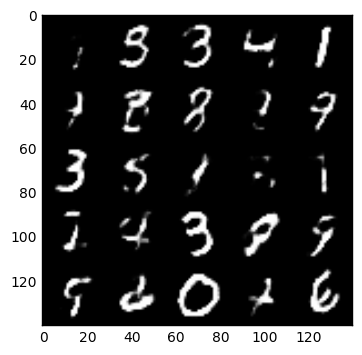

Epoch 2/100... Auto Encoder Loss: 0.6804
Epoch 2/100... Auto Encoder Loss: 0.6792
Epoch 2/100... Auto Encoder Loss: 0.6845
Epoch 2/100... Auto Encoder Loss: 0.6794
Epoch 3/100... Auto Encoder Loss: 0.6804


In [ ]:
batch_size = 32
embedded_dim = 128
learning_rate = 0.0001
beta1 = 0.4
data_shape = 28

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100

# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, embedded_dim, learning_rate, beta1, data_shape, 'L')
    
